# HW3 - Measuring Gender Bias in Pretrained Language Model on Named Entity Recognition - DSCI 531 - Spring 2023

### Please complete the code or analysis under “TODO”. 100pts in total. You should run every cell and keep all the outputs before submitting. Failing to include your outputs will result in zero points.

### Please keep in mind the academic integrity. Plagiarism will be taken seriously.

## Example of using a finetuned BERT on NER

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# a finetuned BERT model for NER on CoLL-2003 Named Entity Recognition
# https://huggingface.co/dslim/bert-base-NER
model_name = 'dslim/bert-base-NER'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

nlp = pipeline(
    "ner", model=model,
    tokenizer=tokenizer,
    device=0)   # the gpu id to use. If no gpu available, set it to -1. Setting it to 0/1/2/3... indicates using the corresponding gpu

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [4]:
# NER on three examples
ner_results = nlp(['Wolfgang lives in Berlin',
                  'Queen is a nurse',
                  'Elizabeth is eating food',
                  'Tennessee is a nurse',
                  'Queen lives in Boston'])

ner_results

[[{'entity': 'B-PER',
   'score': 0.999311,
   'index': 1,
   'word': 'Wolfgang',
   'start': 0,
   'end': 8},
  {'entity': 'B-LOC',
   'score': 0.9995962,
   'index': 4,
   'word': 'Berlin',
   'start': 18,
   'end': 24}],
 [],
 [{'entity': 'B-PER',
   'score': 0.99702424,
   'index': 1,
   'word': 'Elizabeth',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9993932,
   'index': 1,
   'word': 'Tennessee',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9972753,
   'index': 4,
   'word': 'Boston',
   'start': 15,
   'end': 21}]]

#### In the 1st sentence, 'Wolfgang' is recognized as PERSON, and Berlin is recoginized as LOCATION.
#### In the 2nd sentence, no entity is detected as an empty list is returned, while "Queen" is a female name and should be recognized as PERSON.
#### In the 3rd sentence, 'Elizabeth' is recognized as PERSON, which is correct.
#### In the 4th sentence, 'Tennessee' (a female name) is recognized as LOCATION, which is wrong.
#### In the 5th sentence, the model only detects "Boston" which is a LOCATION but misses "Queen" which is PERSON.

## Utility Functions

### Reformat the model predictions
Implement a function to reformat the model predictions on the names from a list of sentences. Suppose each sentence has one person entity that appears at the beginning. In the example shown above, convert ner_results to \[B-PER, O, B-PER, B-LOC, O\]. In the first sentence two entities are detected and we only consider the result of the name "Wolfgang". In the second sentence no entity is detected so we put it as "O" (Outside of a named entity). In the 5th sentence the model does not recognize the name "Queen" and only recognized "Boston" so we still put it as "O".

In [5]:
def reformat_ner_results(ner_results):
    '''
    :param ner_results. The outputs from the model. The format can be seen above.
    return: a list of recognized entities for the name in each sentence
    '''
    formatted_results = [] # List to store formatted entity results
    for sentence_result in ner_results: # Iterate through each sentence's NER output
        if sentence_result:
          # If there is at least one detected entity, take the first entity's type
            first_entity = sentence_result[0]["entity"]
        else:
            first_entity = "O"  # No entity
        formatted_results.append(first_entity)
    return formatted_results

### Metrics

#### Here we implement the three types of errors defined in the [paper](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804). <em>freqs</em> is a list of name frequencies in the sentence, and <em>preds</em> is a list of entity predictions, consisiting of values from {O, B-MIS, I-MIS, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC}.
#### If the prediction is "B-PER" or "I-PERSON", we consider it to be correct.

In [6]:
def type1_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 1 error.
    '''
    total_freq = sum(freqs)
    # Count the frequency of names that are not classified as PERSON
    error_count = sum(freq for freq, pred in zip(freqs, preds) if pred not in ["B-PER", "I-PER"])
    return error_count / total_freq if total_freq > 0 else 0

def type2_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 2 error.
    '''
    total_freq = sum(freqs)
    #Count the frequency of names that are tagged but incorrectly classified as non-PERSON entities
    error_count = sum(freq for freq, pred in zip(freqs, preds) if pred not in ["B-PER", "I-PER", "O"])
    return error_count / total_freq if total_freq > 0 else 0

def type3_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 3 error.
    '''
    total_freq = sum(freqs)
    # Count the frequency of names that are completely unrecognized ("O")
    error_count = sum(freq for freq, pred in zip(freqs, preds) if pred == "O")
    return error_count / total_freq if total_freq > 0 else 0

In [7]:
# Test cases
# Do NOT change the code below!

freqs1 = [10, 20, 30, 15, 8]
preds1 = ['O', 'B-MIS', 'I-PER', 'B-PER', 'B-LOC']
print(type1_error_weighted(freqs1, preds1), type2_error_weighted(freqs1, preds1), type3_error_weighted(freqs1, preds1))


freqs2 = [5, 8, 3, 7, 4]
preds2 = ['B-PER', 'O', 'I-PER', 'O', 'B-LOC']
print(type1_error_weighted(freqs2, preds2), type2_error_weighted(freqs2, preds2), type3_error_weighted(freqs2, preds2))

0.4578313253012048 0.3373493975903614 0.12048192771084337
0.7037037037037037 0.14814814814814814 0.5555555555555556


## NER Inference

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


zip_path = "/content/drive/MyDrive/data_processed.zip"


extract_path = "/content/data_processed"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("解压完成！")

解压完成！


In [10]:
!ls /content/data_processed/data_processed

Template_1  Template_3	Template_5  Template_7	Template_9
Template_2  Template_4	Template_6  Template_8


In [15]:
import os
import glob
#changing file extensions
def fix_all_templates():
    """
    遍历所有 Template_X 目录
    1. 批量修改 `.txt_withsent_...` 文件，使其变成 `.txt`
    """
    base_path = "/content/data_processed"

    for template_idx in range(1, 10):  # 遍历 Template_1 到 Template_9
        template_path = f"{base_path}/Template_{template_idx}"

        if not os.path.exists(template_path):
            print(f"❌ 目录不存在: {template_path}，跳过")
            continue

        print(f"\n📂 处理 {template_path} ...")

        # 查找所有 `_withsent_...` 结尾的文件
        files = glob.glob(f"{template_path}/*.txt_withsent_*")

        for file in files:
            # 去掉 `_withsent_...`，只保留 `.txt`
            new_filename = file.split("_withsent_")[0]
            os.rename(file, new_filename)
            print(f"✅ 修正: {file} → {new_filename}")

    print("\n🎯 所有 `Template_X` 目录文件扩展名修复完成！")

# 运行，修改所有 Template_X 的文件名
fix_all_templates()


📂 处理 /content/data_processed/Template_1 ...

📂 处理 /content/data_processed/Template_2 ...
✅ 修正: /content/data_processed/Template_2/female1929.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/female1929.txt
✅ 修正: /content/data_processed/Template_2/male2005.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/male2005.txt
✅ 修正: /content/data_processed/Template_2/female1940.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/female1940.txt
✅ 修正: /content/data_processed/Template_2/male1942.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/male1942.txt
✅ 修正: /content/data_processed/Template_2/female1991.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/female1991.txt
✅ 修正: /content/data_processed/Template_2/female1958.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/female1958.txt
✅ 修正: /content/data_processed/Template_2/male2004.txt_withsent_isgoingtoschool → /content/data_processed/Template_2/male

In [16]:
!ls /content/data_processed/Template_5 | head -n 10
!ls /content/data_processed/Template_4 | head -n 10
!ls /content/data_processed/Template_3 | head -n 10

female1880.txt
female1881.txt
female1882.txt
female1883.txt
female1884.txt
female1885.txt
female1886.txt
female1887.txt
female1888.txt
female1889.txt
female1880.txt
female1881.txt
female1882.txt
female1883.txt
female1884.txt
female1885.txt
female1886.txt
female1887.txt
female1888.txt
female1889.txt
female1880.txt
female1881.txt
female1882.txt
female1883.txt
female1884.txt
female1885.txt
female1886.txt
female1887.txt
female1888.txt
female1889.txt


In [ ]:
import os
import glob
#This is for me to fix the extension problem, please ignore
def fix_double_txt_extension():

    base_path = "/content/data_processed"

    for template_idx in range(1, 10):  # 遍历 Template_1 到 Template_9
        template_path = f"{base_path}/Template_{template_idx}"

        if not os.path.exists(template_path):
            print(f"❌ 目录不存在: {template_path}，跳过")
            continue

        print(f"\n📂 处理 {template_path} ...")

        # 查找所有 `*.txt.txt` 结尾的文件
        files = glob.glob(f"{template_path}/*.txt.txt")

        for file in files:
            new_filename = file.replace(".txt.txt", ".txt")  # 只保留 `.txt`
            os.rename(file, new_filename)
            print(f"✅ 修正: {file} → {new_filename}")

    print("\n🎯 所有 `*.txt.txt` 文件修复完成！")

# 运行，修正所有 `.txt.txt` 文件
fix_double_txt_extension()


📂 处理 /content/data_processed/Template_1 ...

📂 处理 /content/data_processed/Template_2 ...

📂 处理 /content/data_processed/Template_3 ...

📂 处理 /content/data_processed/Template_4 ...

📂 处理 /content/data_processed/Template_5 ...

📂 处理 /content/data_processed/Template_6 ...

📂 处理 /content/data_processed/Template_7 ...

📂 处理 /content/data_processed/Template_8 ...

📂 处理 /content/data_processed/Template_9 ...

🎯 所有 `*.txt.txt` 文件修复完成！


In [17]:
import os

def load_all_texts():
    """ 预加载所有文本数据，减少 I/O 读取开销 """
    data = {} # Dictionary to store preloaded text data
    for template_idx in range(1, 10):
        for gender in ["male", "female"]:
            for year in range(1880, 2019):
                file_path = f"/content/data_processed/Template_{template_idx}/{gender}{year}.txt"
                if os.path.exists(file_path):
                    with open(file_path, "r") as f:
                        next(f)
                        texts = []
                        freqs = []
                        for line in f:
                            parts = line.strip().split(",")
                            name, _, freq = parts
                            sentence = f"{name} is a template {template_idx}"
                            texts.append(sentence)
                            freqs.append(int(freq))
                        # Store texts and frequencies in dictionary with (year, gender, template_idx) as key
                        data[(year, gender, template_idx)] = (texts, freqs)
                else:
                    data[(year, gender, template_idx)] = ([], [])
    return data

# Preload all text data once at the beginning to minimize repeated disk access
cached_data = load_all_texts()

def ner_inference_errors(year, gender, template_idx):
    """
    year: int.
    gender: str. "male" or "female"
    template_idx: int. 1 to 9
    return: the three errors for year, gender, and the template
    """
    texts, freqs = cached_data.get((year, gender, template_idx), ([], []))

    if not texts:
        print(f"⚠️ 文件未找到或无数据: Template_{template_idx}, {gender}{year}")
        return 0, 0, 0  # 返回零错误

    # Perform batch inference on all sentences at once to maximize GPU efficiency
    ner_results = nlp(texts, batch_size=65536)
    preds = reformat_ner_results(ner_results)

    return type1_error_weighted(freqs, preds), type2_error_weighted(freqs, preds), type3_error_weighted(freqs, preds)

In [19]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00


In [18]:
errors = ner_inference_errors(1880, "female", 3)
print(errors)  # 输出 (Type 1 Error, Type 2 Error, Type 3 Error)

(0.04802369767511445, 0.03521737829508393, 0.01280631938003052)


## Template 1 Analysis

In [19]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 1)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 1)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 1)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 1)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 1)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 1)[2] for year in years]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


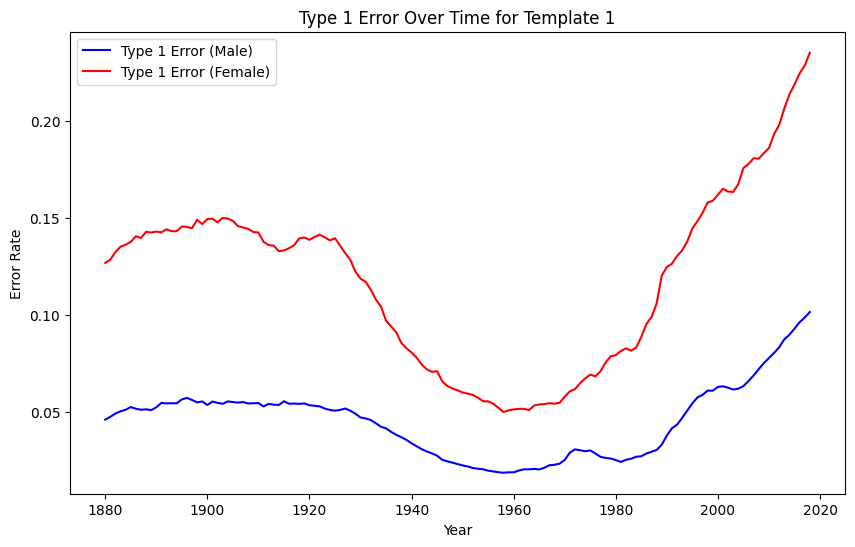

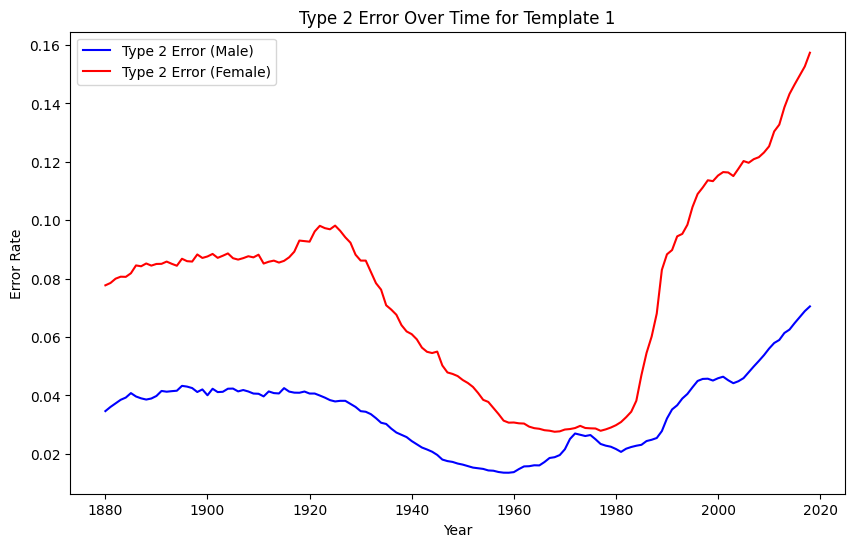

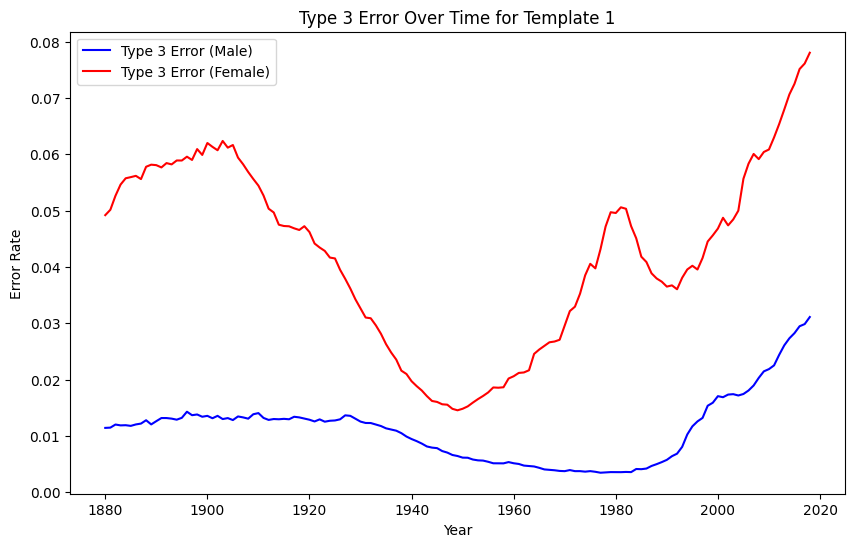

In [20]:
# Visualize the three types of errors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 1")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 1")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 1")
plt.legend()
plt.show()

## Template 2 Analysis

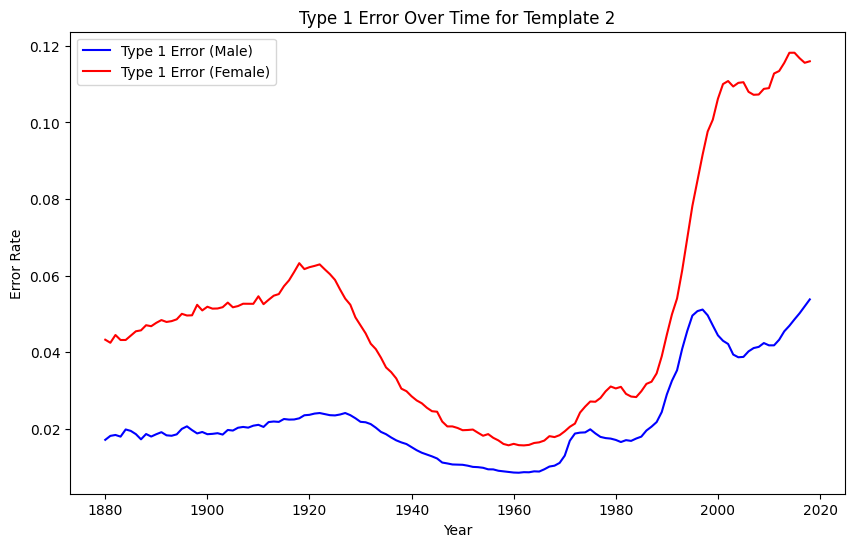

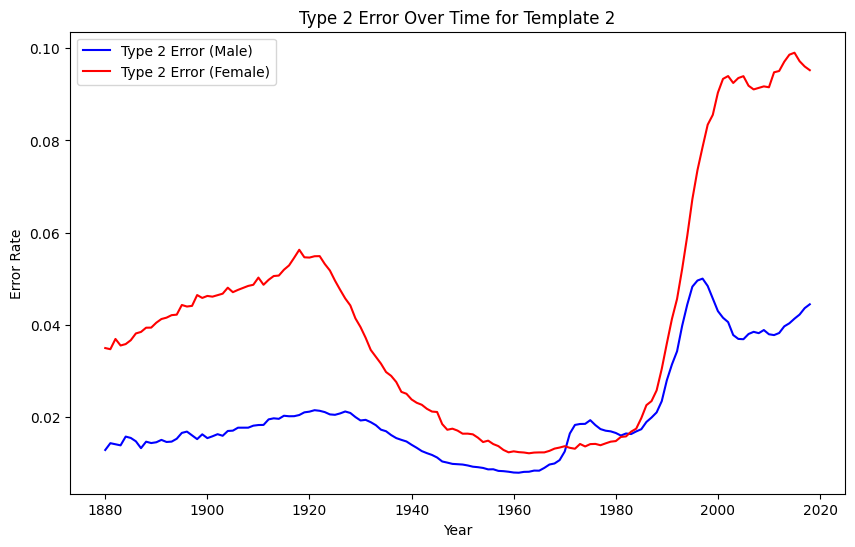

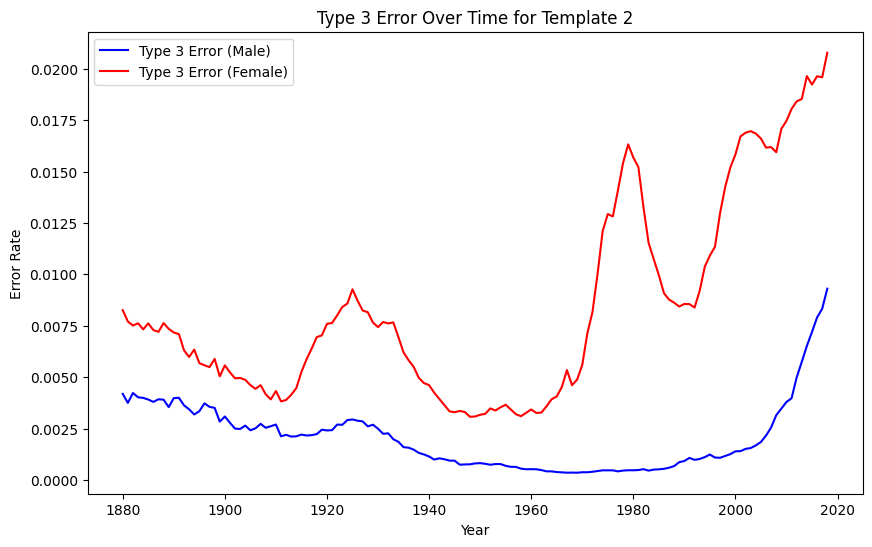

In [26]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 2)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 2)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 2)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 2)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 2)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 2)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 2")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 2")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 2")
plt.legend()
plt.show()

## Template 3 Analysis

In [30]:

# 计算三种错误类型
type1_errors_male = [ner_inference_errors(year, "male", 3)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 3)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 3)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 3)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 3)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 3)[2] for year in years]

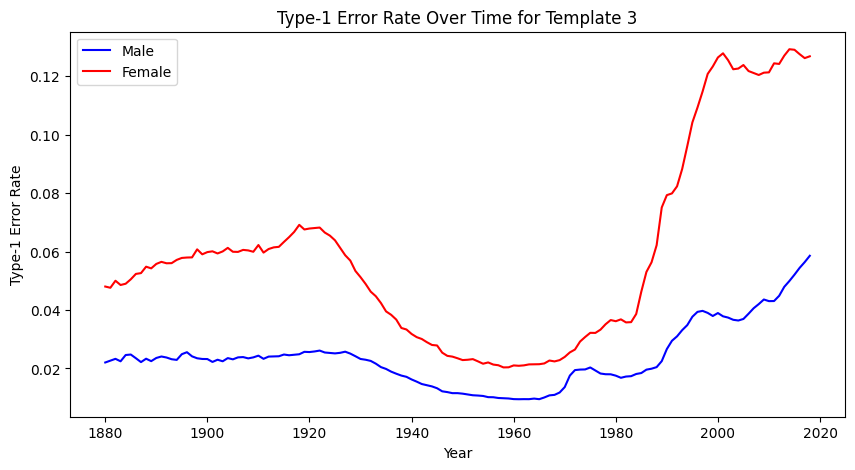

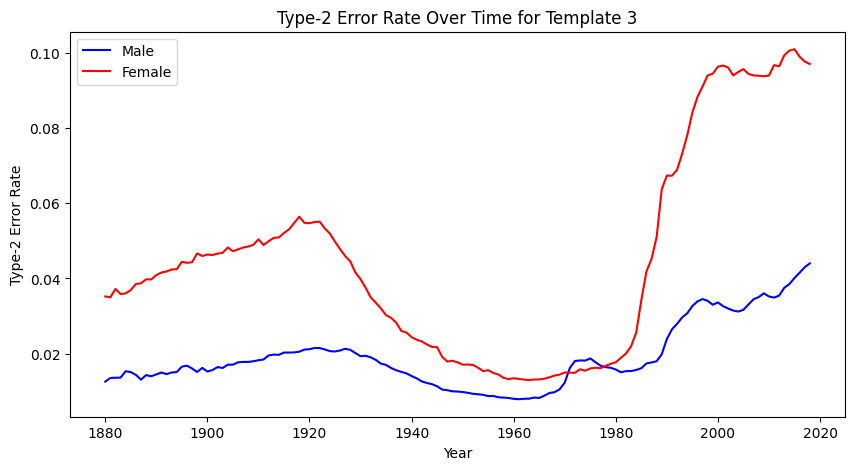

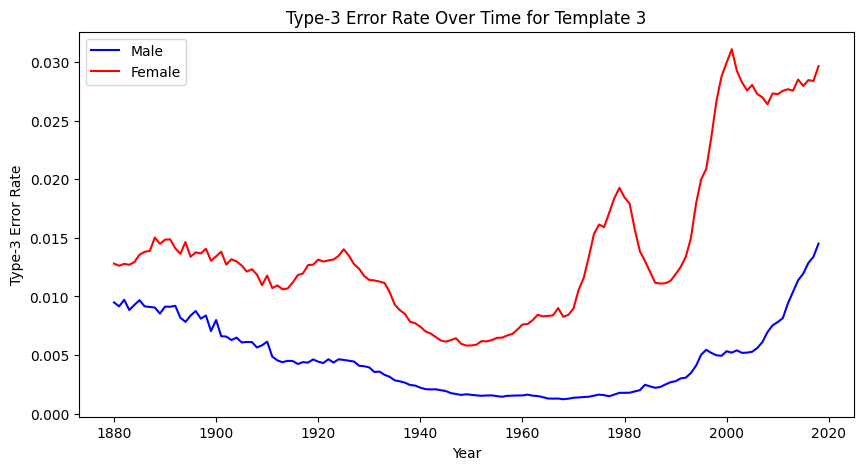

In [31]:
import matplotlib.pyplot as plt

# 绘制 Type-1 错误
plt.figure(figsize=(10, 5))
plt.plot(years, type1_errors_male, label="Male", color="blue")
plt.plot(years, type1_errors_female, label="Female", color="red")
plt.xlabel("Year")
plt.ylabel("Type-1 Error Rate")
plt.title("Type-1 Error Rate Over Time for Template 3")
plt.legend()
plt.show()

# 绘制 Type-2 错误
plt.figure(figsize=(10, 5))
plt.plot(years, type2_errors_male, label="Male", color="blue")
plt.plot(years, type2_errors_female, label="Female", color="red")
plt.xlabel("Year")
plt.ylabel("Type-2 Error Rate")
plt.title("Type-2 Error Rate Over Time for Template 3")
plt.legend()
plt.show()

# 绘制 Type-3 错误
plt.figure(figsize=(10, 5))
plt.plot(years, type3_errors_male, label="Male", color="blue")
plt.plot(years, type3_errors_female, label="Female", color="red")
plt.xlabel("Year")
plt.ylabel("Type-3 Error Rate")
plt.title("Type-3 Error Rate Over Time for Template 3")
plt.legend()
plt.show()

## Template 4 Analysis

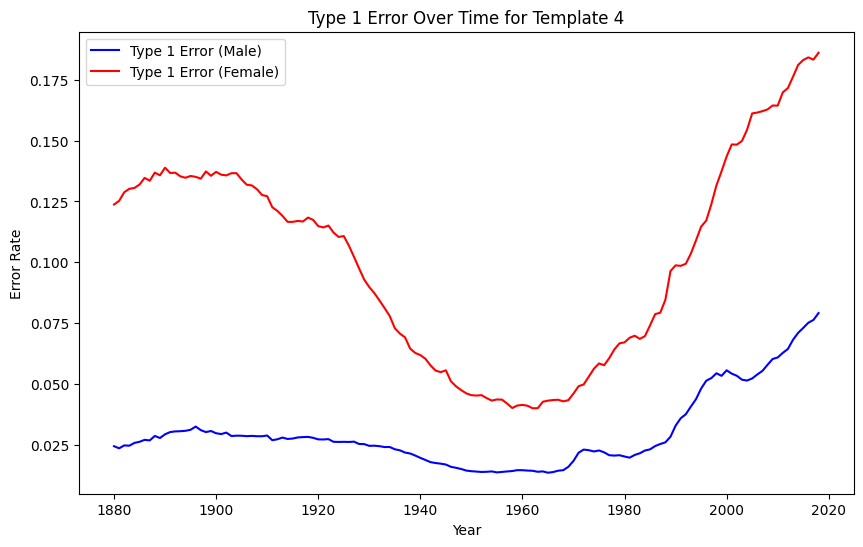

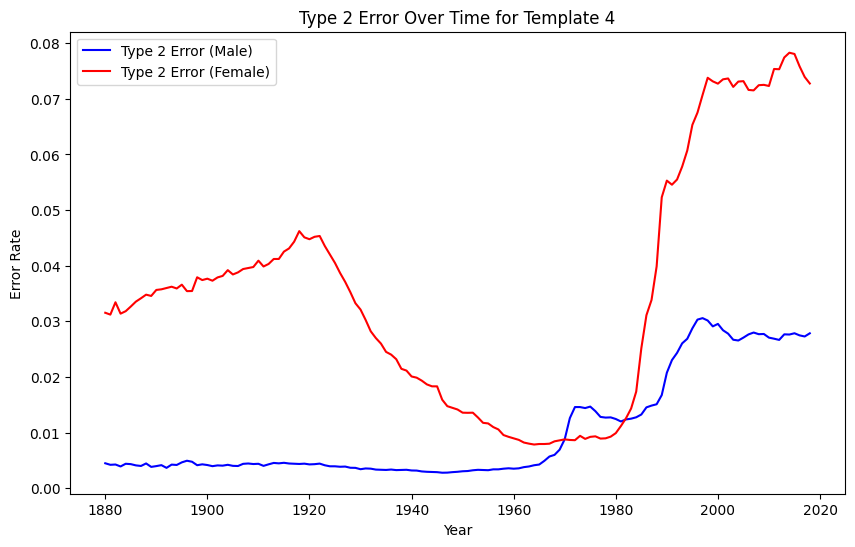

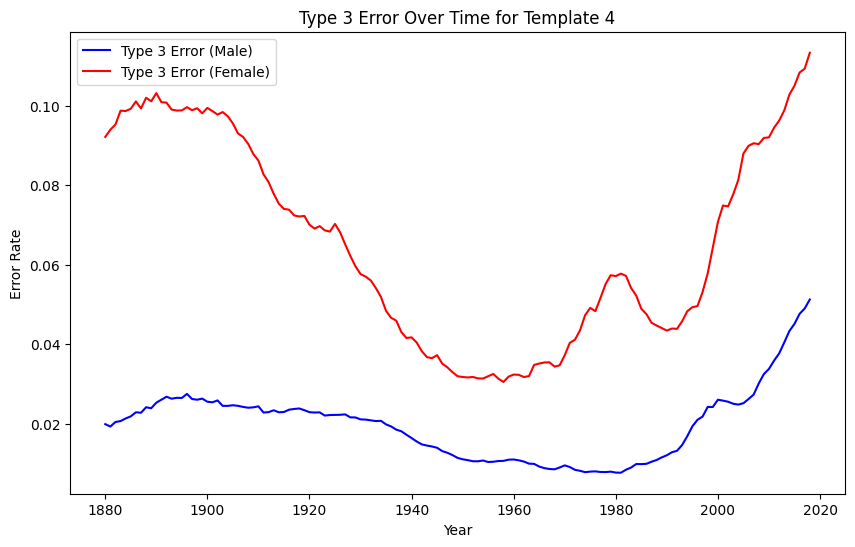

In [33]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 4)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 4)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 4)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 4)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 4)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 4)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 4")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 4")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 4")
plt.legend()
plt.show()

## Template 5 Analysis

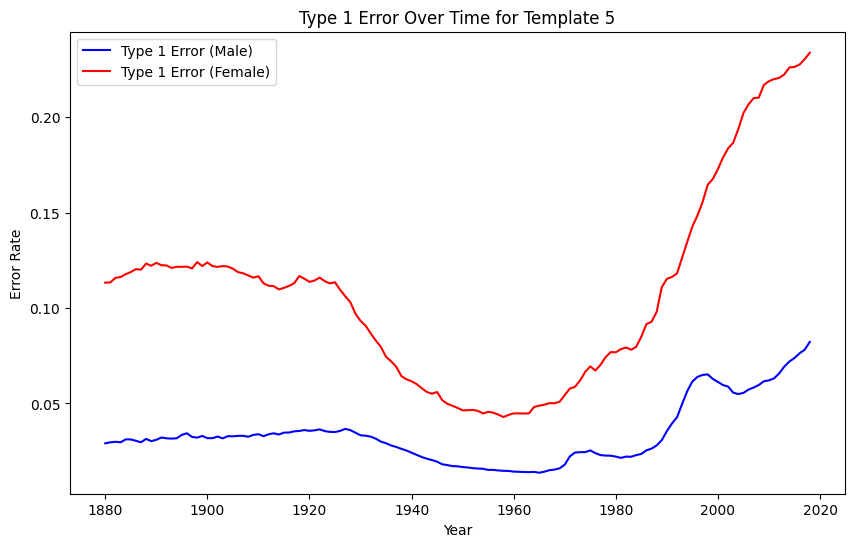

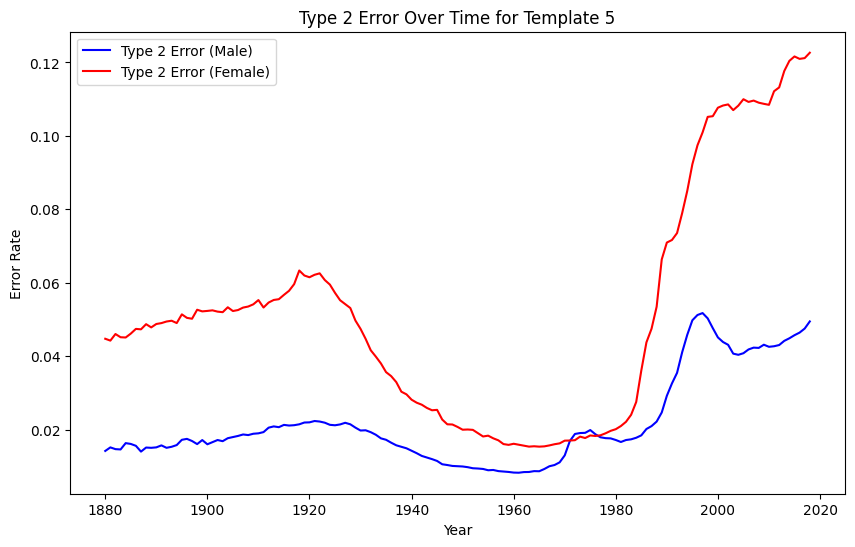

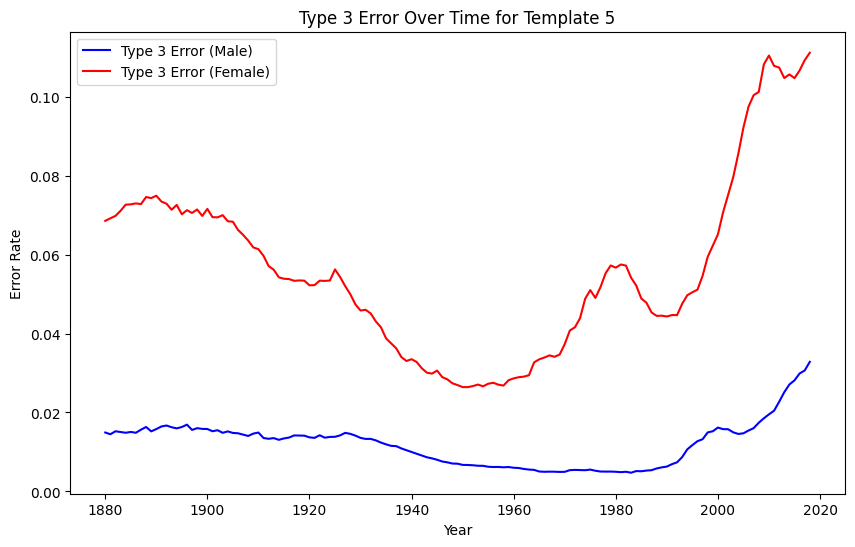

In [34]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 5)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 5)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 5)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 5)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 5)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 5)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 5")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 5")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 5")
plt.legend()
plt.show()

## Template 6 Analysis

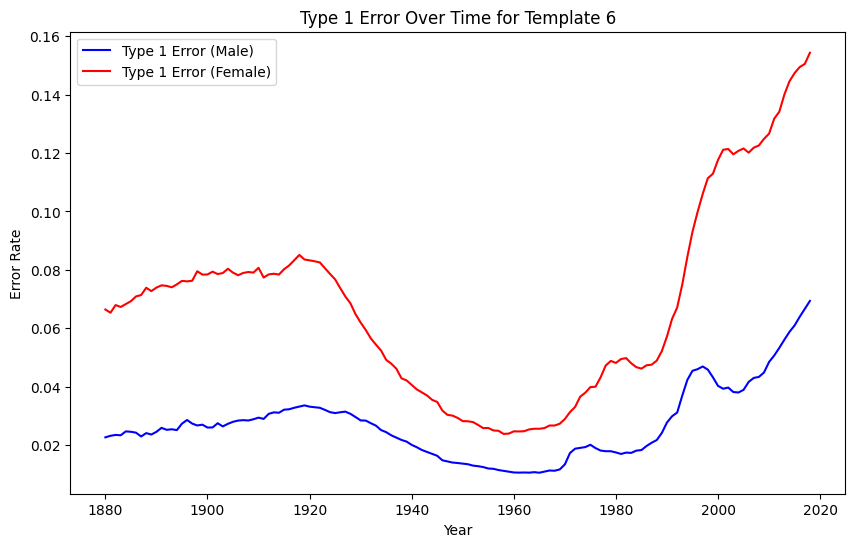

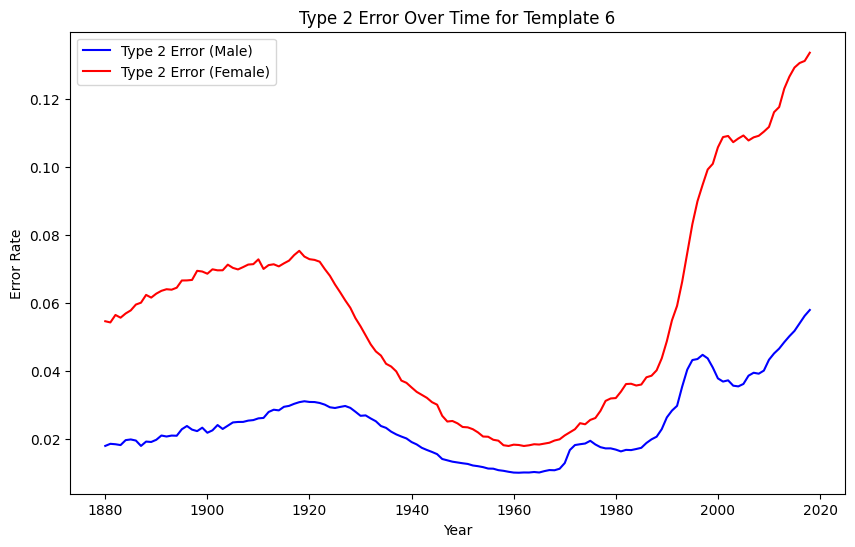

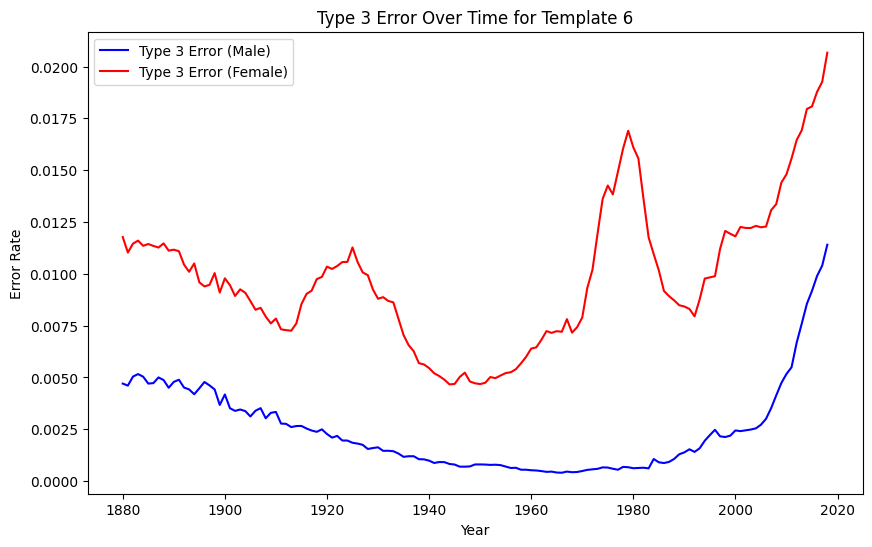

In [35]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 6)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 6)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 6)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 6)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 6)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 6)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 6")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 6")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 6")
plt.legend()
plt.show()

## Template 7 Analysis

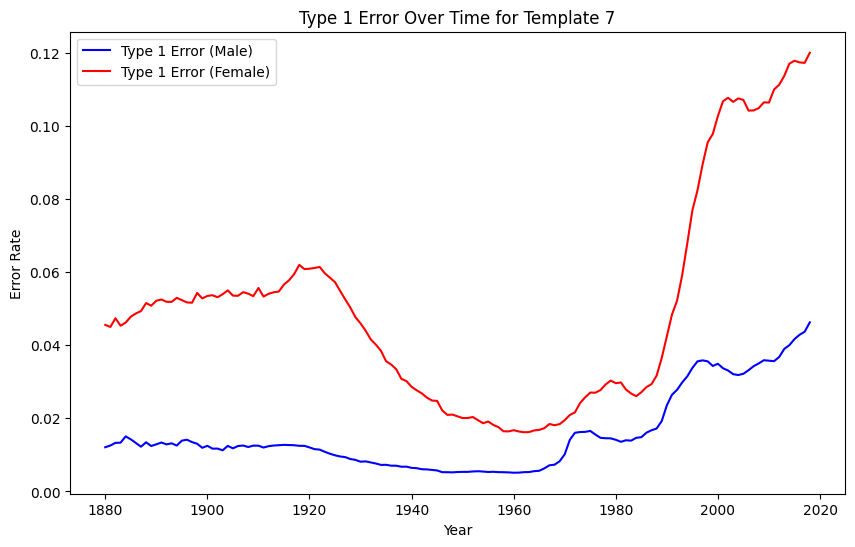

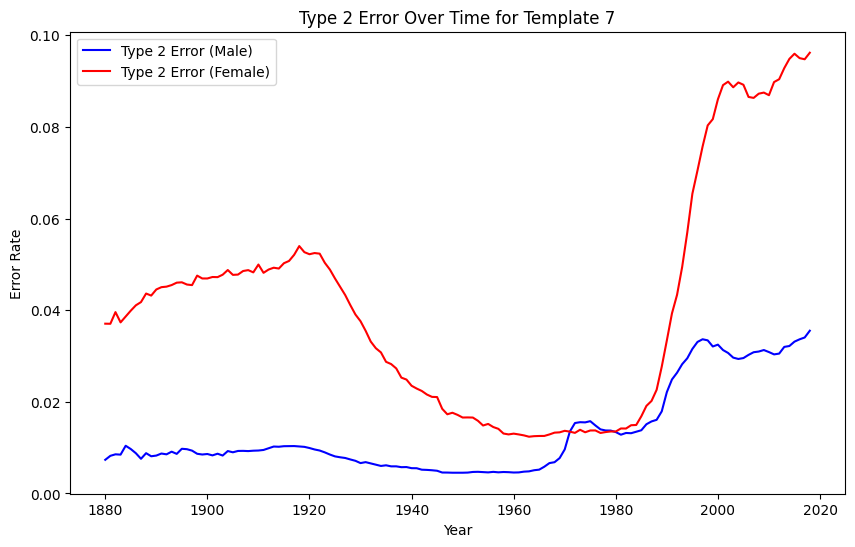

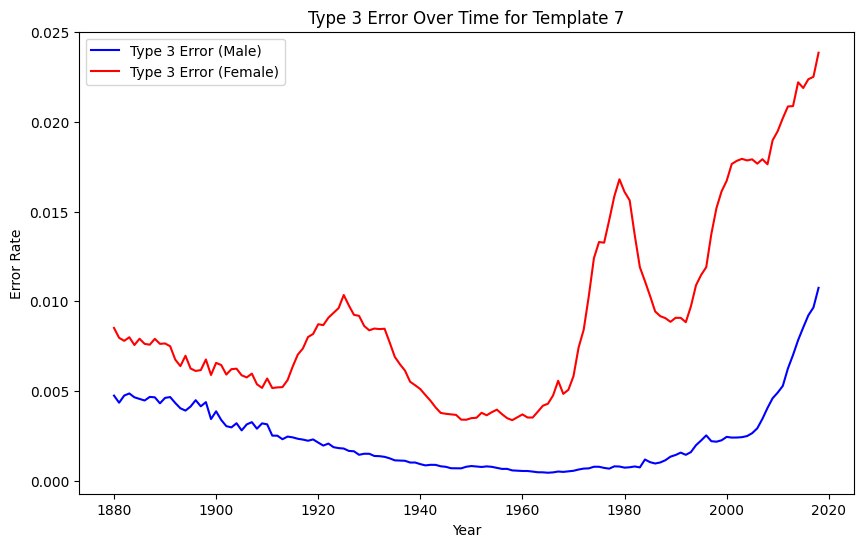

In [36]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 7)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 7)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 7)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 7)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 7)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 7)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 7")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 7")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 7")
plt.legend()
plt.show()

## Template 8 Analysis

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


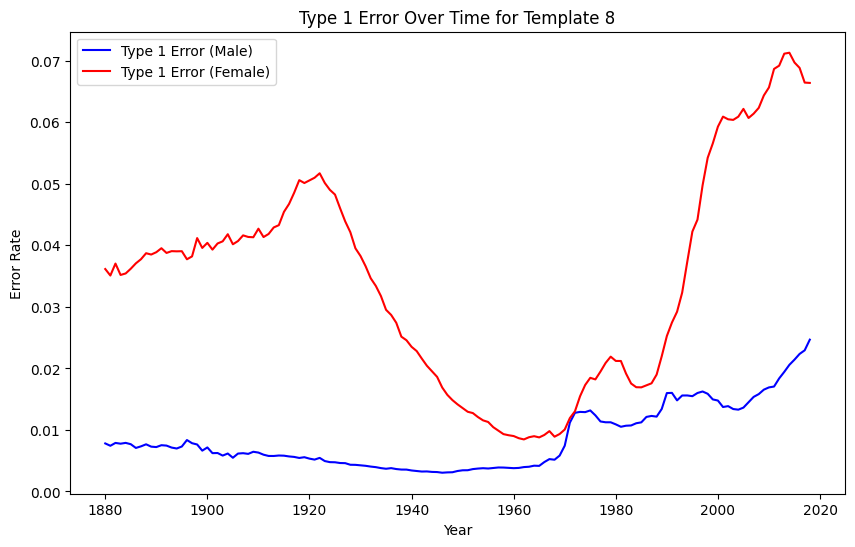

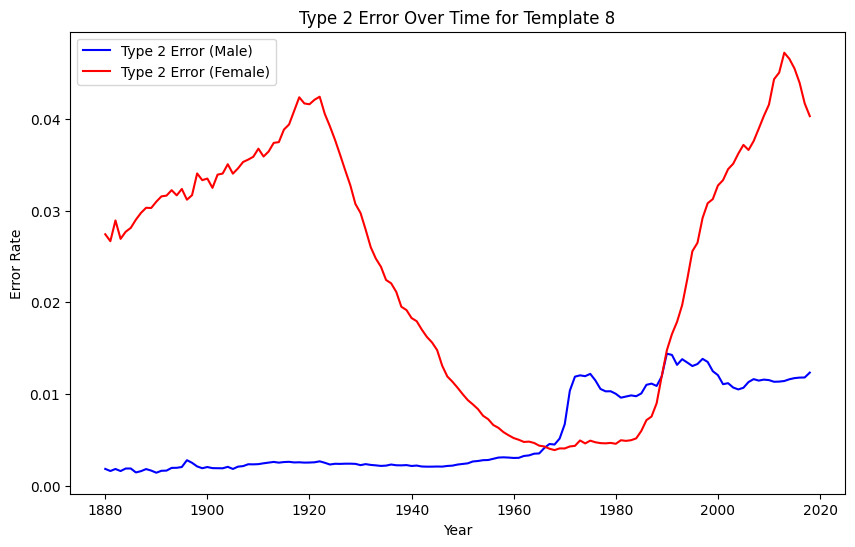

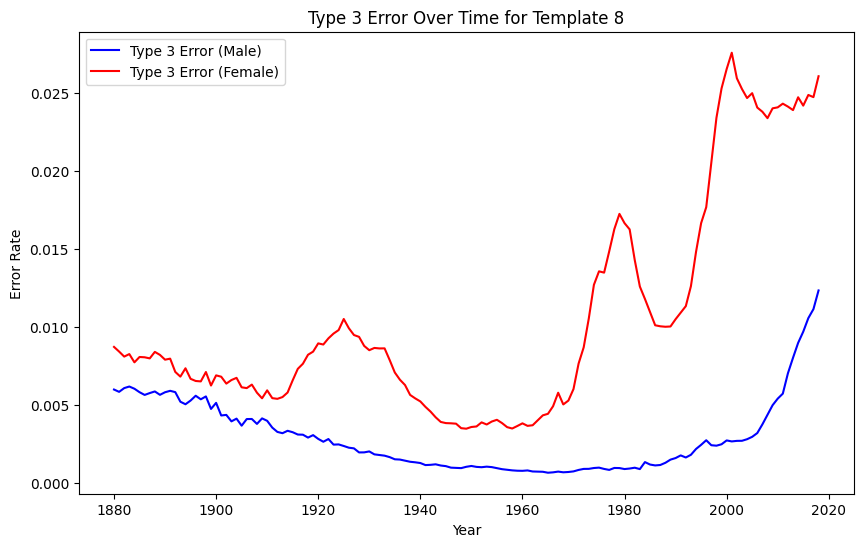

In [21]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 8)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 8)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 8)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 8)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 8)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 8)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 8")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 8")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 8")
plt.legend()
plt.show()

## Template 9 Analysis

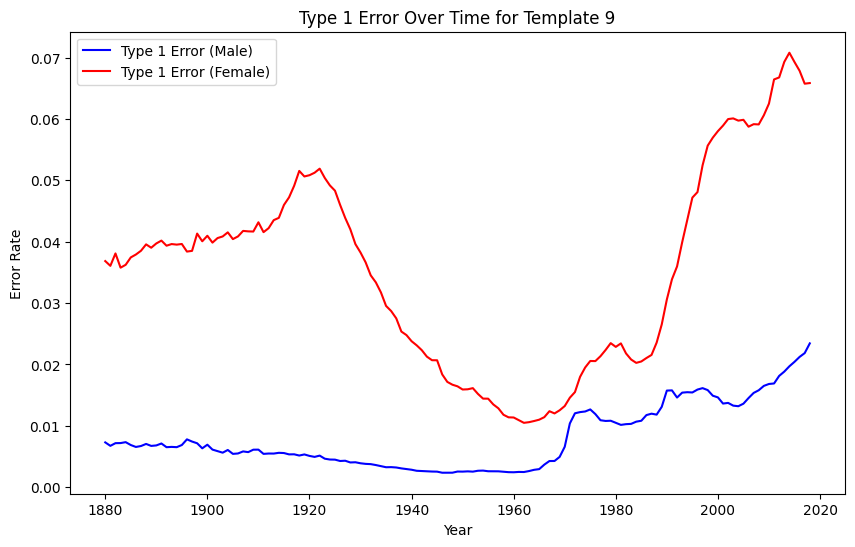

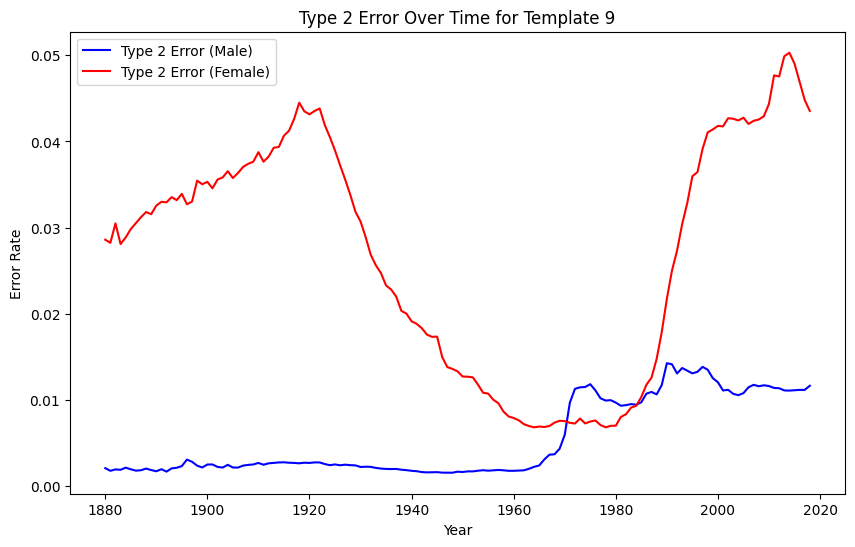

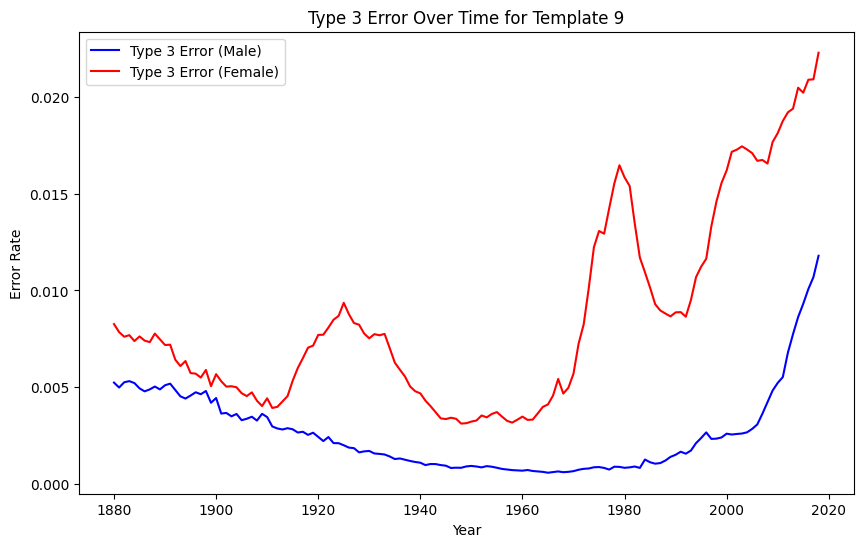

In [22]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019
type1_errors_male = [ner_inference_errors(year, "male", 9)[0] for year in years]
type1_errors_female = [ner_inference_errors(year, "female", 9)[0] for year in years]

type2_errors_male = [ner_inference_errors(year, "male", 9)[1] for year in years]
type2_errors_female = [ner_inference_errors(year, "female", 9)[1] for year in years]

type3_errors_male = [ner_inference_errors(year, "male", 9)[2] for year in years]
type3_errors_female = [ner_inference_errors(year, "female", 9)[2] for year in years]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(years, type1_errors_male, label="Type 1 Error (Male)", color="blue")
plt.plot(years, type1_errors_female, label="Type 1 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 1 Error Over Time for Template 9")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type2_errors_male, label="Type 2 Error (Male)", color="blue")
plt.plot(years, type2_errors_female, label="Type 2 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 2 Error Over Time for Template 9")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, type3_errors_male, label="Type 3 Error (Male)", color="blue")
plt.plot(years, type3_errors_female, label="Type 3 Error (Female)", color="red")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("Type 3 Error Over Time for Template 9")
plt.legend()
plt.show()

### According to the plots you make, do you observe difference in the ability to recognize male and female names as PERSON entity types? How does the difference change over years? How does the difference change across different templates? Checking some error cases, where do you think the bias might come from? Can you think of any possible ways to mitigate the bias? 10pts.

#### <font color="red">Please type your response here.</font>
#### ***************
### Yes, there is a difference in the ability to recognize male and female names as PERSON entity tpes. Specifically, the NER model is better at recognizing male names as PERSON entities compared to female names. The gap of error rates between female and male name recognition has widened over time, indicating growing bias.

### 1 How does the difference change over years?
#### There are 3 periods.
#### 1880-1920. The error rates (Type 1,2,3) for both male and female names are relatively high, but error rates for female names are generally higher than that of male names.
#### 1920-1980. The error rates for female and male names both decreased, but female names error rates are still higher than male names error rates. Additionally, around 1960-1980, there were fluncuations on the rates.
#### 1980 -2020. There is a sharp increase in error rates, especially that of female names. Type 2 errors increased more visibly than type 3 errors.
### 2 How does the difference change across different templates?
#### Templates 1, 4, and 5 show the largest gap between error rates curves for female and male names, with female names being more likely to be misclassified. This is surprising since these 3 templates have the names in a more neutral sentence than the rest of the templates. Templates 2, 3, 6, 7, 8 and 9 have a moderate bias gap. Templates 8 and 9 have the most flunctuating error rates over the years. This might be due to the tight correlation to professions these two templates have. In addition, across all templates, the type 3 error for men and women are the most different.
### 3 Checking some error cases, where do you think the bias might come from?
#### *Contextual Bias* is a possible source of bias. For template 8 and 9 where the names appear in the context of professions (nurse and doctor), there are visible divergence in error rates over time, particularly after 1980 when women started to emerge in more professions. *Training Data Bias in the NER model* is another possibility. If the model was trained on data where male names are labeled more confidently as PERSON while female names more as O, then result in higher tyhpe 3 error rates for female names.
### 4 Can you think of any possible ways to mitigate the bias?
#### Improve Training Data Diversity. More data with more diverse contexts where the names appear in can diversity the training data.  Apply a weighted loss function that increases penalties for misclassify female names would increase the fairness in name recognition, overcoming the training data bias.  